# Imports
Import all the necessary libraries required for the project.

In [33]:
# **Imports**:
%pip install numpy pandas matplotlib seaborn scikit-learn nltk
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
# Added import for Random Forest
from sklearn.ensemble import RandomForestClassifier

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Load Dataset
Load the dataset that will be used for training and testing the model.

In [34]:
# **Load Dataset**
# Load the dataset into a pandas DataFrame
dataset_pathCEAS_08 = '../sample_data/CEAS_08.csv'
dataset_pathNigerian_Fraud = '../sample_data/Nigerian_Fraud.csv'
dataset_pathSpamAssasin = '../sample_data/SpamAssasin.csv'


df1 = pd.read_csv(dataset_pathCEAS_08)
df2 = pd.read_csv(dataset_pathNigerian_Fraud)
df3 = pd.read_csv(dataset_pathSpamAssasin)
df = pd.concat([df1, df2, df3], ignore_index=True)

# Data Preprocessing
Perform data cleaning and preprocessing steps to prepare the data for modeling.

In [35]:
# **Data Preprocessing**
# Check for missing values
missing_values = df.isnull().sum()
df = df.dropna()
missing_values = df.isnull().sum()# Print
print(missing_values)
df.shape

sender      0
receiver    0
date        0
subject     0
body        0
label       0
urls        0
dtype: int64


(45823, 7)

In [59]:
# Additional Preprocessing: Clean text data by removing punctuation, digits, extra spaces, and stopwords.
import re
import string

def clean_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stopwords
    return text

# Apply cleaning function to text fields
df['subject'] = df['subject'].apply(clean_text)
df['body'] = df['body'].apply(clean_text)
print("Applied text cleaning on 'subject' and 'body'.")

Applied text cleaning on 'subject' and 'body'.


# Train Model

Accuracy: 0.9829787234042553
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      8340
           1       0.99      0.98      0.98      9990

    accuracy                           0.98     18330
   macro avg       0.98      0.98      0.98     18330
weighted avg       0.98      0.98      0.98     18330



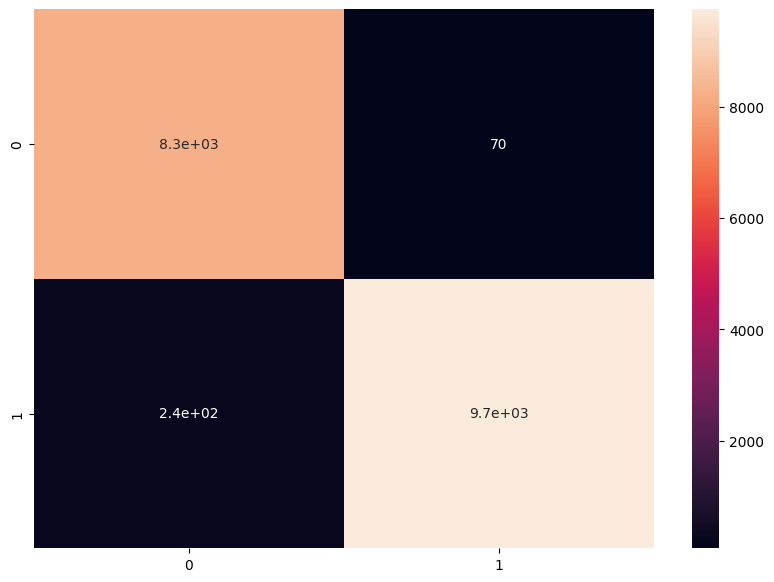

In [ ]:
# Change input to include the full context: Subject and Body concatenated
X = "Subject: " + df["subject"] + ". Body: " + df["body"]
y = df['label']  # Use the 'label' column as the target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Initialize and train a Random Forest model
model = RandomForestClassifier(random_state=1)
# Fit the model to the training data
model.fit(X_train_vec, y_train)
# y_pred is the predicted labels for the test set
y_pred = model.predict(X_test_vec)
# the accuracy score is the ratio of correctly predicted instances to the total instances
accuracy = accuracy_score(y_test, y_pred)
# Evaluate the model
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix as a heatmap with seaborn and matplotlib libraries
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True)
plt.show()

# Save Model

In [61]:
# Save the model to disk
model_path = '../app/model/model.pkl'
with open(model_path, 'wb') as file:
    pickle.dump(model, file)
# Save the vectorizer to disk
vectorizer_path = '../app/model/vectorizer.pkl'
with open(vectorizer_path, 'wb') as file:
    pickle.dump(vectorizer, file)

In [39]:
# prompt: create fucntion to fecth the mdel test a body and return true or false
def predict_text(text, model, vectorizer):
    # Transform the input text using the fitted vectorizer
    text_vec = vectorizer.transform([text])
    # Predict the label
    prediction = model.predict(text_vec)
    # Calculate the probability of each class 
    probabilities = model.predict_proba(text_vec)
    # Return True if predicted label is spam (assuming spam is labeled as 1), otherwise False
    is_spam = prediction[0] == 1
    return is_spam, probabilities

def get_suspect_words(text, model, vectorizer, top_n=5):
    # Transform the input text using the fitted vectorizer
    text_vec = vectorizer.transform([text])

    # Get feature names (words) from the vectorizer
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Get feature importances from the RandomForestClassifier
    feature_importances = model.feature_importances_

    # Get the nonzero feature indices in the transformed input
    word_indices = text_vec.nonzero()[1]

    # Get word importance scores
    word_importance = feature_importances[word_indices]

    # Pair words with their importance scores and sort them
    word_contributions = sorted(zip(feature_names[word_indices], word_importance), key=lambda x: abs(x[1]), reverse=True)

    # Return the top N suspect words
    return word_contributions[:top_n]
# Example usage: Predict using title and body in the format: {subject}. Body: {body}
subject = "Your Email Title"
body_text = "Your email content goes here"
sample_text = f"{subject}. Body: {body_text}"
is_spam, probabilities = predict_text(sample_text, model, vectorizer)
print("Is Spam:", is_spam)
print("Probabilities:", probabilities)
top_words = get_suspect_words(sample_text, model, vectorizer, top_n=5)
print("Top Suspect Words:", top_words)
# Example usage Subject: {subject}. Body: {body}” so that the model sees the full context. 
sample_text = "Hay send me your other email so I can forward it to you" 
is_spam, probabilities = predict_text(sample_text, model, vectorizer)
print("Is Spam:", is_spam)
print("Probabilities:", probabilities)
top_words = get_suspect_words(sample_text, model, vectorizer, top_n=5)
print("Top Suspect Words:", top_words)


Is Spam: True
Probabilities: [[0.15 0.85]]
Top Suspect Words: [('body', np.float64(0.021079458556763922)), ('email', np.float64(0.0021618695937983433)), ('title', np.float64(0.00015757168823768073)), ('goes', np.float64(0.00012441256006306655)), ('content', np.float64(0.00010267879681582953))]
Is Spam: True
Probabilities: [[0.3 0.7]]
Top Suspect Words: [('email', np.float64(0.0021618695937983433)), ('send', np.float64(0.000886050400295083)), ('forward', np.float64(0.00026109593494647905)), ('it', np.float64(6.931419949036034e-06)), ('can', np.float64(6.500332705713231e-06))]


In [40]:
subject = "Your Email Title"
test_body = "We detected that your password has been exposed in a data breach on another platform while doing a routine check for your security. You should reset your Duolingo password immediately, using a unique password not used elsewhere."
test_text = f"{subject}. Body: {test_body}"
is_spam, percentages = predict_text(test_text, model, vectorizer)
suspect_words = get_suspect_words(test_text, model, vectorizer)

if is_spam:
    print("The email is a phishing email. With a probability of", percentages[0][1].round(2)*100, "%")
else:
    print("The email is not a phishing email. With a probability of", percentages[0][0].round(2)*100, "%")

print("Top 5 suspect words:", suspect_words)

The email is not a phishing email. With a probability of 68.0 %
Top 5 suspect words: [('body', np.float64(0.021079458556763922)), ('using', np.float64(0.0036109840322067505)), ('email', np.float64(0.0021618695937983433)), ('used', np.float64(0.0016061349324382973)), ('data', np.float64(0.001571869949512627))]
